In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from plato.planets.metrics import PlanetPopulationMetrics
from plato.planets.populations import PopulationModel
from plato.stars import filter_valid_targets
from plato.visualisation import FigureProcessor, get_palette, set_plot_defaults
from plato.utils import get_abspath

In [3]:
set_plot_defaults()

figure_directory = f"/figures/07_planet_population_metrics/"
save = True

In [4]:
LOPS2 = pd.read_csv(get_abspath() + f"data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(get_abspath() + f"data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[
    [
        "Radius",
        "Mass",
        "[Fe/H]",
        "u1",
        "u2",
        "gaiaV",
        "n_cameras",
        "Population",
    ]
]

fields["cos_i"] = 0
fields["sigma_star"] = 10e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

In [5]:
metrics = PlanetPopulationMetrics()

## Recreate NGPPS II Table 7

In [6]:
metric_table = {}

for num_embryos in [10, 20, 50, 100]:
    population_model = PopulationModel(
        fields,
        num_embryos=num_embryos,
        additional_columns=["Population"],
    )

    mock = population_model.create_mock_population(additional_columns=["Population"])

    table = metrics.calculate_metrics(
        mock,
        by_population=True,
        number_of_systems={
            pop: len(fields[fields["Population"] == pop])
            for pop in fields["Population"].unique()
        },
    )
    metric_table[num_embryos] = table

metric_table = (
    pd.concat(metric_table, axis=1)
    .reindex(
        index=pd.MultiIndex.from_product(
            [
                [
                    "Thin Disk",
                    # "Thick Disk Candidate",
                    "Thick Disk",
                    # "Halo Candidate",
                    "Halo",
                ],
                ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
            ],
        )
    )
    .round(3)
)

In [7]:
metric_table

10                                   \
                       Number of Planets System Fraction Occurrence Rate   
Thin Disk  Earth                  194543           0.564           1.130   
           Super-Earth            247079           0.688           1.435   
           Neptunian               60572           0.287           0.352   
           Sub-Giant               24733           0.136           0.144   
           Giant                   46317           0.181           0.269   
Thick Disk Earth                    9338           0.575           1.084   
           Super-Earth             15982           0.765           1.855   
           Neptunian                2755           0.258           0.320   
           Sub-Giant                1741           0.197           0.202   
           Giant                    1861           0.143           0.216   
Halo       Earth                     437           0.588           0.934   
           Super-Earth              1354           0.944           2.893   
           Neptunian                  61           0.122           0.130   
           Sub-Giant                 173           0.370           0.370   
           Giant                      31           0.043           0.066   

                                                  20                   \
                       Multiplicity Number of Planets System Fraction   
Thin Disk  Earth              2.002            354744           0.653   
           Super-Earth        2.085            342556           0.752   
           Neptunian          1.224             65108           0.310   
           Sub-Giant          1.057             20342           0.099   
           Giant              1.482             47206           0.179   
Thick Disk Earth              1.884             17860           0.667   
           Super-Earth        2.424             19566           0.810   
           Neptunian          1.238              3457           0.331   
           Sub-Giant          1.028              1112           0.105   
           Giant              1.506              1859           0.142   
Halo       Earth              1.589               877           0.620   
           Super-Earth        3.063              1247           0.938   
           Neptunian          1.070               182           0.342   
           Sub-Giant          1.000                54           0.071   
           Giant              1.550                38           0.051   

                                                                  50   \
                       Occurrence Rate Multiplicity Number of Planets   
Thin Disk  Earth                 2.060        3.156          658065.0   
           Super-Earth           1.989        2.646          535392.0   
           Neptunian             0.378        1.221           55755.0   
           Sub-Giant             0.118        1.193           15908.0   
           Giant                 0.274        1.528           43328.0   
Thick Disk Earth                 2.073        3.109           35018.0   
           Super-Earth           2.271        2.802           20195.0   
           Neptunian             0.401        1.211            1624.0   
           Sub-Giant             0.129        1.230             428.0   
           Giant                 0.216        1.518            1174.0   
Halo       Earth                 1.874        3.024            2022.0   
           Super-Earth           2.665        2.841             400.0   
           Neptunian             0.389        1.138              20.0   
           Sub-Giant             0.115        1.636               4.0   
           Giant                 0.081        1.583               9.0   

                                                                     \
                       System Fraction Occurrence Rate Multiplicity   
Thin Disk  Earth                 0.806           3.822        4.743   
           Super-Earth           0.718         

In [8]:
# calculate the total number of planets
total_planet_number = (
    pd.DataFrame(
        metric_table[((n, "Number of Planets") for n in [10, 20, 50, 100])]
        .sum(axis=0)
        .reset_index(level=1, drop=True),
    )
    .rename(columns={0: "Total Number of Planets"})
    .rename_axis("Number of Embryos")
)
total_planet_number

,Total Number of Planets
Number of Embryos,
10,606977.0
20,876208.0
50,1369342.0
100,1652691.0


## GET UNCERTAINTIES FOR HALO PLANETS, ALSO METALLICITY CUT

In [31]:
halo_table = defaultdict(dict)

for num_embryos in [10, 20, 50, 100]:
    for metallicity_name, metallicity_cut in {
        "Halo (Without [Fe/H] Cut)": None,
        "Halo (With [Fe/H] Cut)": -0.6,
    }.items():
        halo_population_model = PopulationModel(
            fields[fields["Population"] == "Halo"],
            num_embryos=num_embryos,
            additional_columns=["Population"],
        )

        halo_mocks = [
            halo_population_model.create_mock_population(
                additional_columns=["Population"],
                metallicity_limit=metallicity_cut,
            )
            for _ in range(300)
        ]

        halo_metrics = [
            metrics.calculate_number_of_planets(
                mock,
            )
            for mock in halo_mocks
        ]

        halo_metrics_stats = metrics.calculate_metrics_stats(
            halo_metrics,
            grouping_column="Planet Category",
            format_uncertainties=True,
            round_decimals="ceil",
            to_int=True,
            new_col_name="",
        )

        halo_table[num_embryos][metallicity_name] = halo_metrics_stats

halo_table = pd.concat(
    {key: pd.concat(val, axis=0) for key, val in halo_table.items()},
    axis=1,
)
halo_table.columns = halo_table.columns.droplevel(1)
halo_table = halo_table.reindex(
    ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
    level=1,
)

In [32]:
num_planets = (
    metric_table[:]["Number of Planets"]
    .drop(
        index=["Halo"],
        level=0,
    )
    .rename(
        index={
            "Without Limit": "Halo (Without [Fe/H] Cut])",
            "With Limit": "Halo (With [Fe/H] Cut)",
        },
        level=0,
    )
)
num_planets.columns = [10, 20, 50, 100]

halo_table = pd.concat([num_planets.round(0).astype(int), halo_table], axis=0)

In [33]:
halo_table

10                  20   \
Thin Disk                 Earth                    194543              354744   
                          Super-Earth              247079              342556   
                          Neptunian                 60572               65108   
                          Sub-Giant                 24733               20342   
                          Giant                     46317               47206   
Thick Disk                Earth                      9338               17860   
                          Super-Earth               15982               19566   
                          Neptunian                  2755                3457   
                          Sub-Giant                  1741                1112   
                          Giant                      1861                1859   
Halo (Without [Fe/H] Cut) Earth         $420^{+24}_{-23}$   $874^{+37}_{-36}$   
                          Super-Earth  $1298^{+33}_{-27}$  $1292^{+35}_{-37}$   
                          Neptunian      $81^{+11}_{-10}$   $185^{+13}_{-12}$   
                          Sub-Giant      $165^{+10}_{-9}$     $52^{+9}_{-10}$   
                          Giant            $32^{+7}_{-6}$      $32^{+7}_{-7}$   
Halo (With [Fe/H] Cut)    Earth           $56^{+11}_{-8}$   $114^{+17}_{-15}$   
                          Super-Earth    $104^{+9}_{-12}$   $126^{+12}_{-13}$   
                          Neptunian        $19^{+5}_{-5}$      $20^{+5}_{-4}$   
                          Sub-Giant        $11^{+3}_{-3}$      $10^{+4}_{-4}$   
                          Giant            $13^{+4}_{-4}$      $12^{+5}_{-4}$   

                                                      50                  100  
Thin Disk                 Earth                    658065              793085  
                          Super-Earth              535392              660036  
                          Neptunian                 55755               60057  
                          Sub-Giant                 15908               17123  
                          Giant                     43328               45746  
Thick Disk                Earth                     35018               45434  
                          Super-Earth               20195               24414  
                          Neptunian                  1624                1772  
                          Sub-Giant                   428                 472  
                          Giant                      1174                1197  
Halo (Without [Fe/H] Cut) Earth        $1924^{+63}_{-59}$  $2843^{+75}_{-75}$  
                          Super-Earth   $385^{+29}_{-27}$   $423^{+33}_{-30}$  
                          Neptunian         $6^{+3}_{-2}$       $6^{+3}_{-2}$  
                          Sub-Giant         $2^{+1}_{-1}$       $2^{+2}_{-1}$  
                          Giant             $5^{+2}_{-2}$       $5^{+2}_{-2}$  
Halo (With [Fe/H] Cut)    Earth         $236^{+25}_{-25}$   $310^{+24}_{-27}$  
                          Super-Earth   $104^{+14}_{-16}$   $125^{+17}_{-15}$  
                          Neptunian         $6^{+3}_{-3}$       $6^{+3}_{-3}$  
                          Sub-Giant         $1^{+2}_{-0}$       $2^{+2}_{-1}$  
                          Giant             $5^{+2}_{-3}$       $5^{+2}_{-2}$

In [28]:
# print(halo_table.astype(str).to_latex())

## OCCURENCE RATE PLOT

/tmp/ipykernel_3552906/2417850370.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  occurence_rate_barplot = sns.barplot(



/tmp/ipykernel_3552906/2417850370.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  occurence_rate_barplot = sns.barplot(



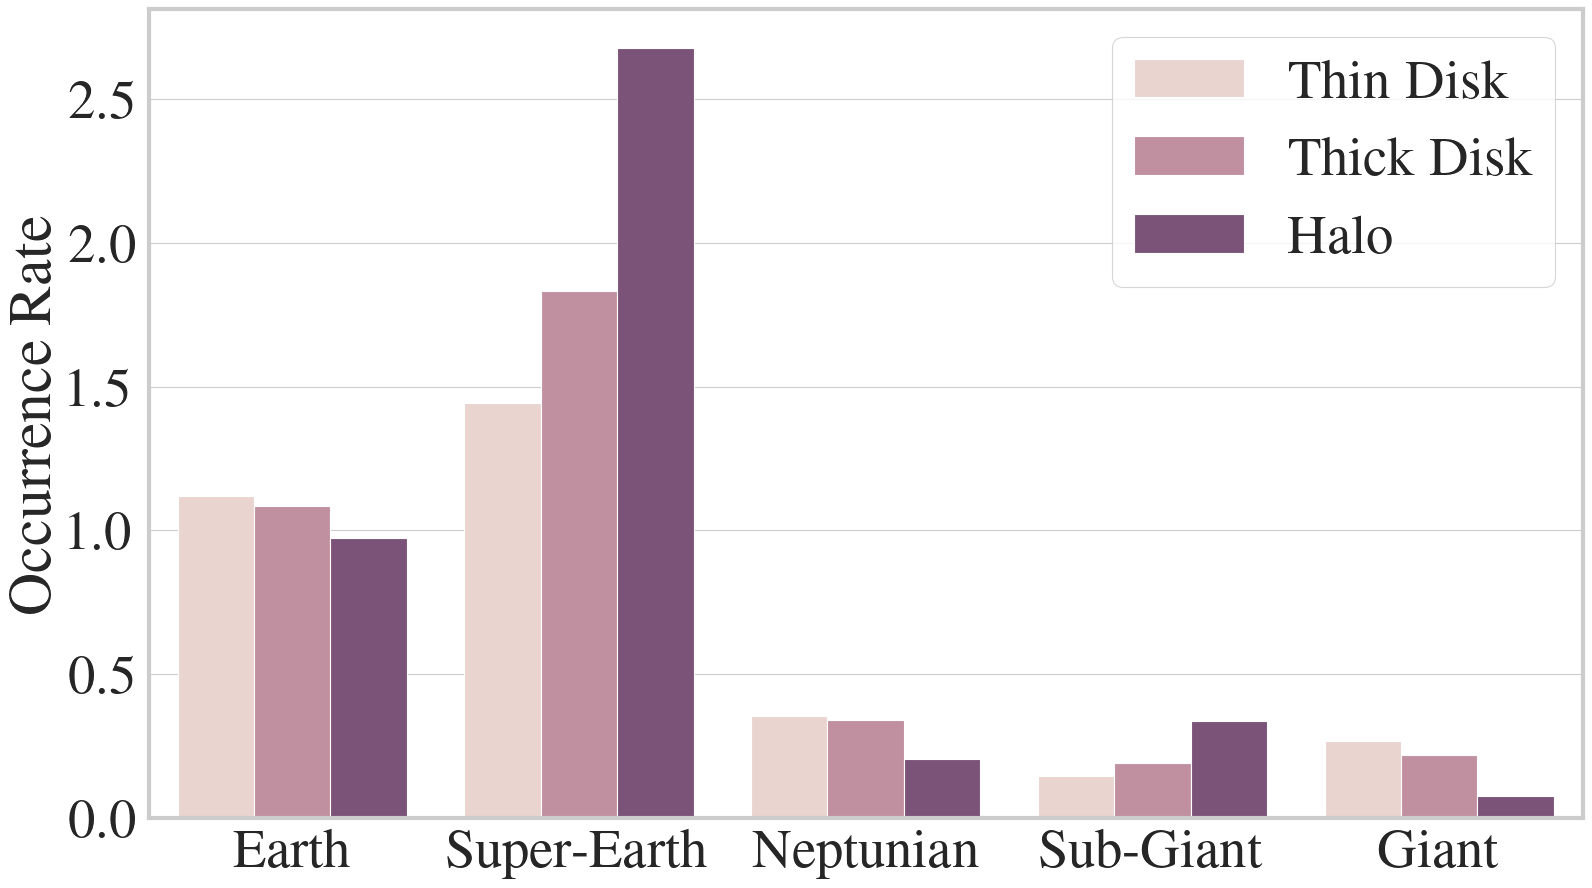

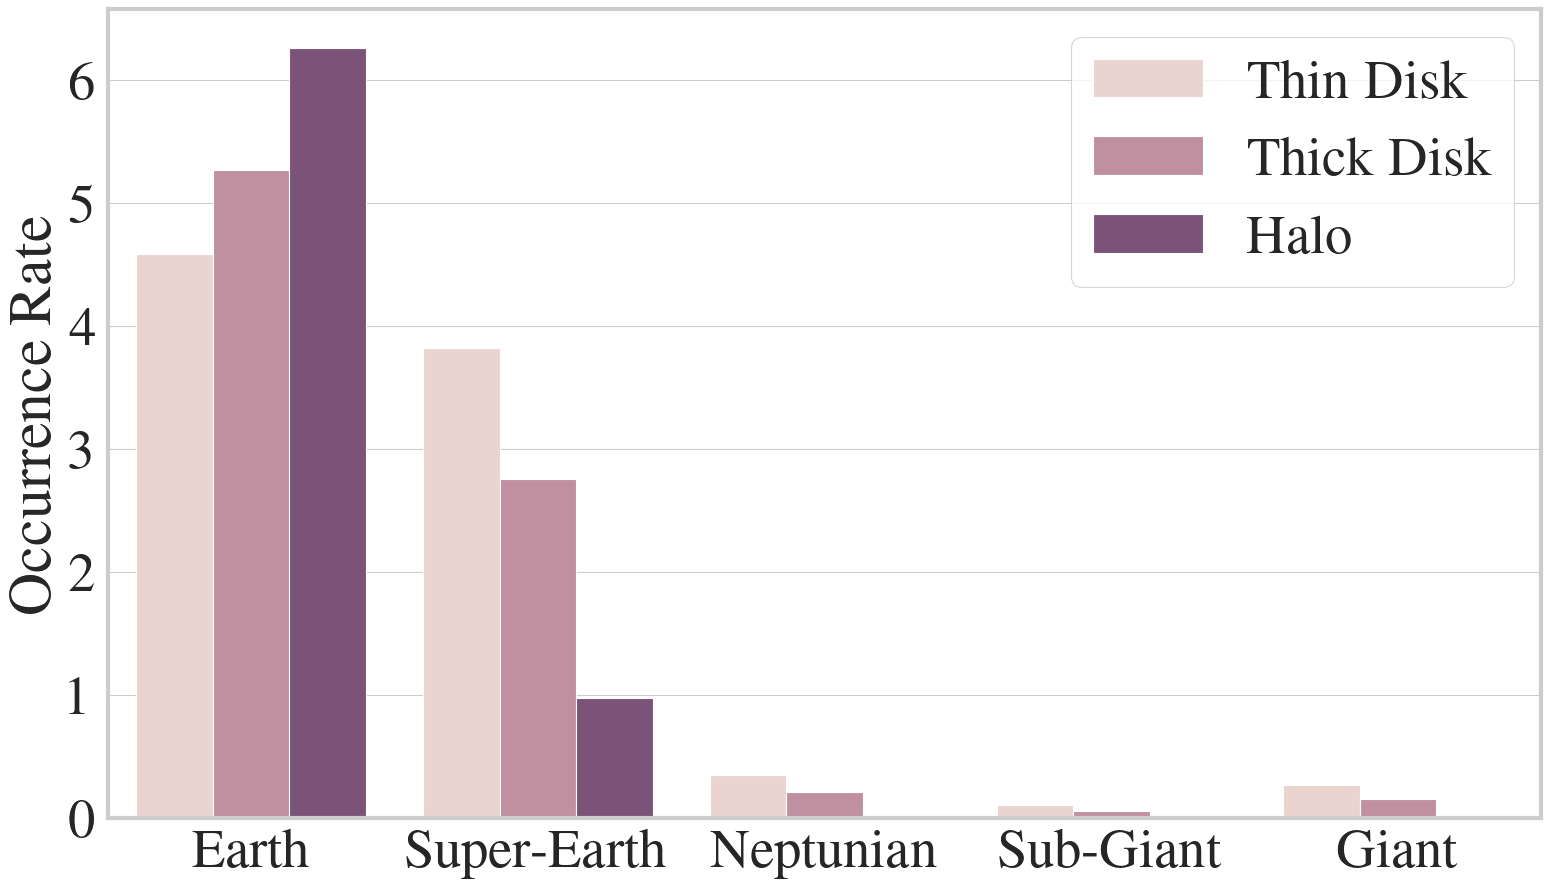

In [13]:
components = ["Thin Disk", "Thick Disk", "Halo"]

for num_embryos in [10, 100]:
    plt.figure()
    occurence_rates = metric_table[num_embryos]["Occurrence Rate"].reset_index()
    occurence_rates.rename(
        columns={"level_0": "Population", "level_1": "Planet Category"}, inplace=True
    )

    occurence_rate_barplot = sns.barplot(
        data=occurence_rates,
        x="Planet Category",
        y="Occurrence Rate",
        hue="Population",
        hue_order=components,
        palette=get_palette(n_colors=4),
    )
    occurence_rate_barplot.set_xlabel("")
    occurence_rate_barplot.legend(title="")

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_N_Embryos={num_embryos}.pdf",
        figure_directory=figure_directory,
        save=save,
    )